In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h3
import json
import numpy as np

In [2]:
actual_lengths = []
predicted_lengths = []
total_clusters = 57

In [3]:
for i in range(total_clusters):
    checkpoint = torch.load(f"zone_results/best_checkpoint_{i}.pt", weights_only=False)
    predicted_lengths.append(checkpoint["val_avg_tour_length"])
    actual_lengths.append(checkpoint["actual_length"])

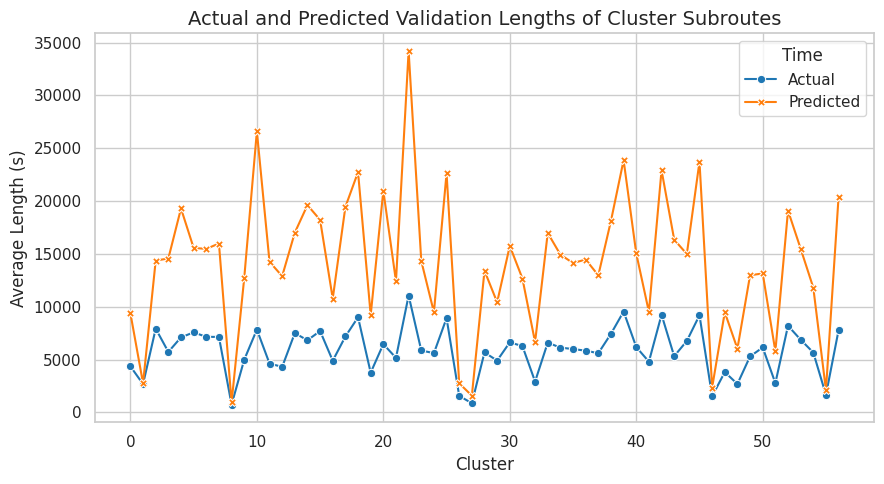

In [4]:
sns.set_theme(style="whitegrid")

df = pd.DataFrame({
    'Cluster': list(range(total_clusters)) * 2,
    'Average length (s)': actual_lengths + predicted_lengths,
    'Time': ['Actual'] * total_clusters + ['Predicted'] * total_clusters
})

plt.figure(figsize=(9, 5))
sns.lineplot(data=df, x='Cluster', y='Average length (s)', hue='Time', style='Time',
             markers=True, dashes=False, palette=['#1f77b4', '#ff7f0e'])

# Títulos y etiquetas
plt.title('Actual and Predicted Validation Lengths of Cluster Subroutes', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Average Length (s)')
plt.tight_layout()

plt.show()

In [2]:
df = pd.read_parquet("../df_la_test.parquet")

In [3]:
with open("zone_dfs/labels_dict.json") as f:
    labels_dict = json.load(f)

In [4]:
df.loc[:, "h3_index"] = df.apply(lambda row: h3.latlng_to_cell(row["lat"], row["lng"], res=6), axis=1)
df.loc[:, "cluster"] = df.apply(lambda row: labels_dict.get(row["h3_index"], -1.0), axis=1)
# df

In [7]:
df[df["cluster"] == -1.0]["route_id"].nunique()

50

/tmp/ipykernel_56427/3592597106.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(routes_per_cluster_count.index)


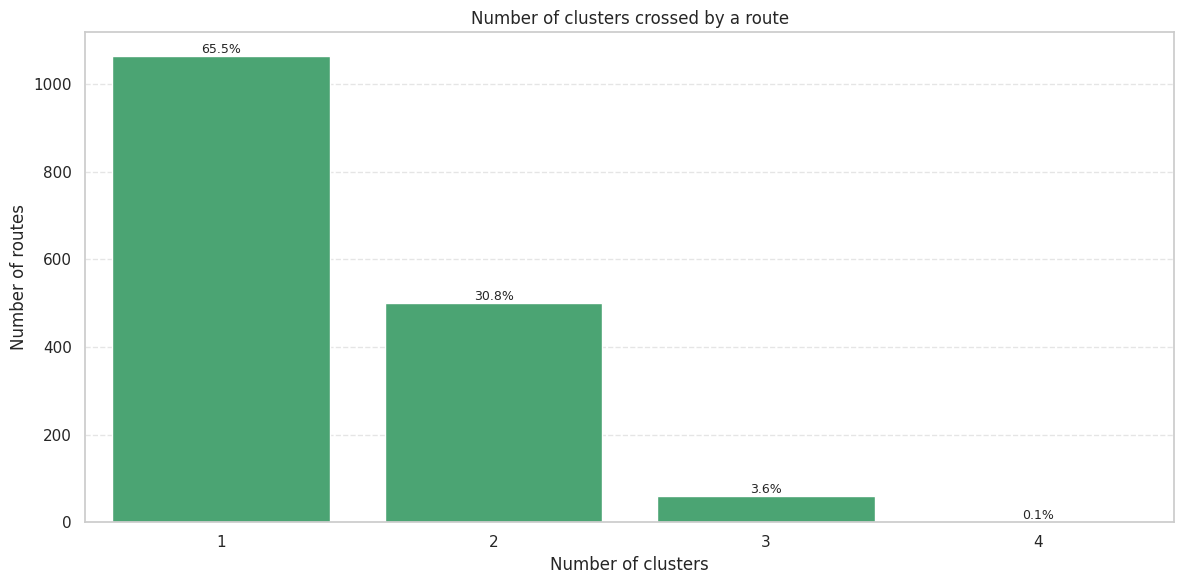

In [14]:
values_per_route = df[df["type"] != "Station"].groupby(by="route_id")["cluster"].nunique()

routes_per_cluster_count = values_per_route.value_counts().sort_index()

total_routes = routes_per_cluster_count.sum()


sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))

ax = sns.barplot(
    x=routes_per_cluster_count.index,
    y=routes_per_cluster_count.values,
    color='mediumseagreen'
)

for bar, count in zip(ax.patches, routes_per_cluster_count.values):
    percent = (count / total_routes) * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{percent:.1f}%',
        ha='center',
        va='bottom',
        fontsize=9
    )

# Etiquetas y título
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Number of routes')
ax.set_title('Number of clusters crossed by a route')

ax.set_xticklabels(routes_per_cluster_count.index)

ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

plt.show()

In [11]:
sum_times = [] # Sum of epochs per cluster
mean_times = [] # Mean of epochs per cluster

for i in range(57):
    try:
        with open(f"zone_times/times_{i}.json", "r") as f:
                times = json.load(f)
                sum_times.append(np.sum(times))
                mean_times.append(np.mean(times))
    except:
        pass

In [6]:
np.sum(sum_times) # Sum of train times of all clusters

np.float64(101391.45881390572)

In [7]:
np.mean(sum_times) # Mean of cluster train times

np.float64(1810.5617645340305)

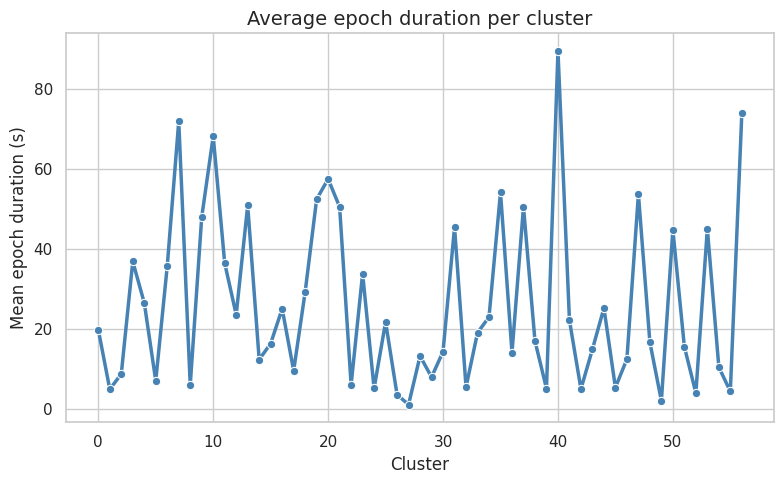

In [12]:
df_line = pd.DataFrame({
    'Clusters': list(range(len(mean_times))),
    'Mean epoch time (s)': mean_times
})

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))

ax = sns.lineplot(
    data=df_line,
    x='Clusters',
    y='Mean epoch time (s)',
    marker='o',
    linewidth=2.5,
    color='steelblue'
)

# for x, y in zip(df_line['Clusters'], df_line['Mean epoch time (s)']):
#     ax.text(x, y + 0.5, f'{y:.1f}', ha='center', va='bottom', fontsize=9)

ax.set_title('Average epoch duration per cluster', fontsize=14)
ax.set_xlabel('Cluster')
ax.set_ylabel('Mean epoch duration (s)')

plt.tight_layout()
plt.grid(True)
plt.show()

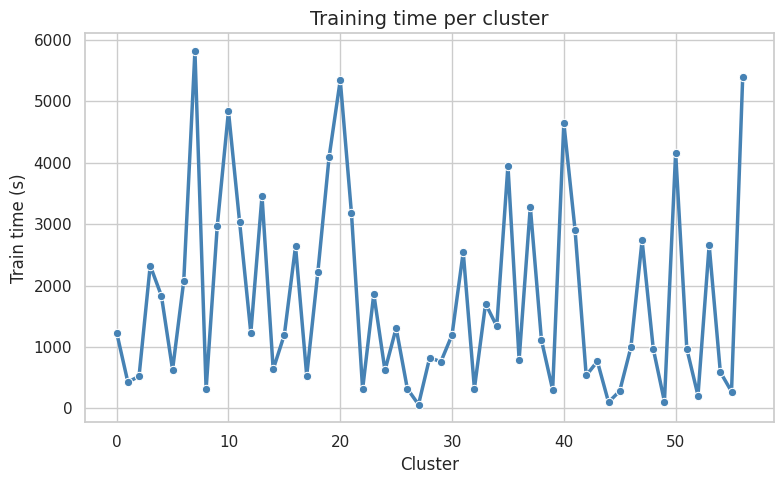

In [13]:
df_line = pd.DataFrame({
    'Clusters': list(range(len(sum_times))),
    'Train time (s)': sum_times
})

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))

ax = sns.lineplot(
    data=df_line,
    x='Clusters',
    y='Train time (s)',
    marker='o',
    linewidth=2.5,
    color='steelblue'
)

# for x, y in zip(df_line['Clusters'], df_line['Mean epoch time (s)']):
#     ax.text(x, y + 0.5, f'{y:.1f}', ha='center', va='bottom', fontsize=9)

ax.set_title('Training time per cluster', fontsize=14)
ax.set_xlabel('Cluster')
ax.set_ylabel('Train time (s)')

plt.tight_layout()
plt.grid(True)
plt.show()